# Portfolioprojekt: Depression prediction with the best mdel (method-file to choose the bst model)

The project was given from:

https://www.kaggle.com/datasets/shahzadahmad0402/depression-and-anxiety-data/code


***
We have the following tasks:
* Data reading and cleaning,
* Feature Engineering,
* Optimal model, fit the dates to the model and grid-search of different models,
* Combination to the pipeline,
* Chossing the best model with the optimal columns.
***


The data-set is given with th columns

| **Column** | **Description** |
| ------------ | :-----------------: |
| id | each number is a participant in the experiment |
| school_year | years in school |
| age | |
| gender | |
| bmi | body mass index |
| who_bmi | bmi category |
| phq_score | measure the severity of symptoms related to depression, anxiety, and other related disorders in patients |
| depression_severity | degree or intensity of symptoms experienced by an individual with depression |
| depressiveness | |
| suicidal | the candidate have suicide thought |
| depression_diagnosis | the candidate already have depression diagnosis |
| depression_treatment | the candidate already have depression treatment |
| gad_score | measure that assesses the severity of Generalized Anxiety Disorder |
| anxiety_severity |  intensity of symptoms experienced by an individual with anxiety |
| anxiousness | |
| anxiety_diagnosis | the candidate already have anxiety diagnosis |
| anxiety_treatment | the candidate already have anxiety treatment |
| epworth_score |  score to assess daytime sleepiness ytime sleepiness |
| sleepiness | |

### Define Metric

We apply the F1-matric to get a balance between the precision and recall.

In [9]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score


# Metrics considerations

# Accuracy: The proportion of correct predictions. 
            # In your case this metric might be less important, 
           # I may have an unbalanced dataset (more good purchases than bad purchases).
# Better metrics
# Recall (Sensitivity): The proportion of correctly identified bad purchases out of all 
# actual bad purchases. Here I optimize: Identify as many bad purchases as possible.
# Precision: The proportion of correctly identified bad purchases out of all as bad purchases 
# predicted cars. Important to minimize false purchases.
# It is best to weight between the two:
# F1-Score: The harmonic mean of precision and recall. 
# Here I have to find a balance between precision and recall.

# We apply the F1-score

### Gather Data

We have the dataset: *depression_anxiety_data.csv*. With the target-column: 'depressiveness

In [10]:
# import modules 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Modelle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Pipeline
from sklearn.pipeline import Pipeline
# Columntransormer
from sklearn.compose import ColumnTransformer
# OneHotEndode,, Scaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Train/Test Splitt, Crossvaue-Score, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures



In [11]:
# Target encoder

!pip install category_encoders
import category_encoders as ce



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Trainee\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## EDA

**EDA**:
Here, we apply only a brief EDA, while the full EDA is done on the EDA-files

In [12]:

# read data (start from the dataset)
df = pd.read_csv("data/depression_anxiety_data.csv")

display(df.head())
#print(df)



,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,depressiveness,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness
0,1,1,19,male,33.333333,Class I Obesity,9,Mild,False,False,False,False,11,Moderate,True,False,False,7.0,False
1,2,1,18,male,19.841270,Normal,8,Mild,False,False,False,False,5,Mild,False,False,False,14.0,True
2,3,1,19,male,25.102391,Overweight,8,Mild,False,False,False,False,6,Mild,False,False,False,6.0,False
3,4,1,18,female,23.738662,Normal,19,Moderately severe,True,True,False,False,15,Severe,True,False,False,11.0,True
4,5,1,18,male,25.617284,Overweight,6,Mild,False,False,False,False,14,Moderate,True,False,False,3.0,False


## Data Preparation

Here, we apply the cleaing of the data based on our EDA in the "eda_model_depression.ipynb"  file

In [13]:
# Cleaning of the full data set, before the splitt based on the targets

import pandas as pd

def clean_data_target(df, target_columns=None):
    """
    Cleans and transforms the input DataFrame.

    This function performs the following operations on the DataFrame:
        - Drops rows with any missing values (NaNs) in the specified target columns.
        - Converts binary categorical features into numerical values (0 and 1).
        - Converts datetime features to the appropriate datetime format.
        - Returns the cleaned DataFrame.

    Args: 
        df (pd.DataFrame): The data to clean.
        target_columns (list of str, optional): List of target column names for NaN removal. 
                                                If None, no target-specific NaN removal is performed.
        
    Returns:
        pd.DataFrame: A cleaned DataFrame with transformed features.
    """
    
    # Drop rows with missing values in the specified target columns
    if target_columns:
        df_clean = df.dropna(subset=target_columns)
    else:
        df_clean = df.copy()

    # Further cleaning or transformation can be added here if needed
    
    return df_clean

# Define the target of the dataset

target = ['depressiveness']

df = clean_data_target(df, target)



General data-cleaning after the splitt

In [14]:
# Data Cleaning and Transformation Function, this is done for the train and test datasets
def clean_data(X, y=None):
    """Cleans and transforms the input feature DataFrame and optionally the target.

    This function performs the following operations on the feature DataFrame (X):
        - Drops rows with any missing values (NaNs) in either X or y to ensure they remain aligned.
        - Converts binary categorical features into numerical values (0 and 1).
        - Optionally, cleans and transforms the target DataFrame (y) if provided.
        - Converts datetime features to the appropriate datetime format.
        - Returns the cleaned features and optionally the cleaned target.

    Args: 
        X (pd.DataFrame): The feature data.
        y (pd.DataFrame, optional): The target data. Default is None.
        
    Returns:
        pd.DataFrame: A cleaned DataFrame with transformed features.
        pd.DataFrame: Optionally, the cleaned target DataFrame if y is provided.
    """
    # Concatenate X and y to handle missing values across both simultaneously
    if y is not None:
        # Combine X and y into a single DataFrame for joint NaN removal
        combined = pd.concat([X, y], axis=1)
        
        # Drop rows with any missing values in either X or y
        combined_clean = combined.dropna()
        
        # Separate X and y again
        X_clean = combined_clean.iloc[:, :X.shape[1]]
        y_clean = combined_clean.iloc[:, X.shape[1]:]
    else:
        # If y is not provided, only clean X
        X_clean = X.dropna()

    # List of categorical columns with binary values that need to be converted to integers
    cat_cols_trans = ['gender', 'depression_diagnosis', 'depression_treatment',  
                      'anxiety_diagnosis', 'sleepiness']

    # Map 'gender' column to integers: 'male' -> 1, 'female' -> 0
    X_clean['gender'] = X_clean['gender'].map({'male': 1, 'female': 0})

    # Convert the specified binary categorical columns in X to integers (0 and 1)
    X_clean[cat_cols_trans] = X_clean[cat_cols_trans].astype(int)

    if y is not None:
        # Convert all target variables to integers
        y_clean = y_clean.astype(int)
        # Return both cleaned X and cleaned y
        return X_clean, y_clean
    else:
        # If y is not provided, return only the cleaned features
        return X_clean




# We apply the data-cleaning after the train-test split

## Train-Test-Split

In diesem Projekt brauchst du sowohl die Trainings- als auch die Test- und Zieldaten. 

Die Testdaten haben wir nicht vorgegeben. Deshalb empfehlen wir dir an dieser Stelle, die Daten in ein Trainings- und Testset zu teilen und mit dem Trainingsset so zu arbeiten, als wären dies alle Daten, die du zur Verfügung hast. Wenn du dein Modell dann fertig gebaut hast, kannst du mit dem Testset simulieren, was passiert, wenn neue Daten in deine Datenpipeline hereinkommen, also beispielsweise neue Autos auf Auktionsplattformen angeboten werden.

Denke immer daran: **Always fit on Train Set only!** Das gilt inbesondere auch für die Datenbereinigung und das *Feature Engineering*. Im Idealfal fasst du dein Testset nur einmal an, und zwar, wenn du ein für dich optimales Modell gebaut und evaluiert hast und wissen möchtest, wie gut es auf ungesehenen Daten performt. Stell dir einfach vor, du hättest das Testset gar nicht vorliegen.

Nutze `train_test_split` aus dem Submodul `sklearn.model_selection`, um die Daten in Test- und Trainingsset aufzuteilen. Übergebe die folgenden Parameter: `random_state=42` und `test_size=0.1`, damit du deine Vorhersagen später mit unserem Modell vergleichen kannst und eine erste Einschätzung erhältst. Speichere zusätzlich `features_test` als *features_test.csv* ab.

In [15]:
# read data (start from the dataset)
df = pd.read_csv("data/depression_anxiety_data.csv")


# perform train-test-split


# Feature-Matrix und Zielvektor definieren
features = df.drop(columns=['depressiveness'])
target = df['depressiveness']

# Daten aufteilen in Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, test_size=0.1, random_state=42)




# Testdaten speichern und Target speichern
features_test.to_csv('features_test.csv', index=False)
target_test.to_csv('target_test.csv', index=False)


In [16]:
# Clean the data:

features_train, target_train = clean_data(features_train, target_train)

display(features_train.head())
display(target_train.head())


# Preparation of the test-data-set
features_test, target_test = clean_data(features_test, target_test)

display(features_test.head())
display(target_test.head())

# save features_test as 'features_test.csv'

,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness
181,182,1,18,1,29.536862,Overweight,1,None-minimal,False,0,0,1,None-minimal,False,0,False,3.0,0
54,55,1,18,0,21.773842,Normal,6,Mild,False,0,0,5,Mild,False,0,False,11.0,1
734,735,4,22,0,22.718974,Normal,3,None-minimal,False,0,0,5,Mild,False,0,False,5.0,0
365,366,2,20,1,23.566632,Normal,3,None-minimal,False,0,0,8,Mild,False,0,False,5.0,0
97,98,1,18,0,25.636917,Overweight,6,Mild,False,0,0,3,None-minimal,False,0,False,1.0,0


,depressiveness
181,0
54,0
734,0
365,0
97,0


,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness
597,598,3,21,1,22.545959,Normal,4,None-minimal,False,0,0,0,None-minimal,False,0,False,8.0,0
589,590,3,21,1,26.365603,Overweight,1,None-minimal,False,0,0,1,None-minimal,False,0,False,6.0,0
208,209,1,21,1,24.897060,Normal,15,Moderately severe,False,0,1,5,Mild,False,0,False,1.0,0
291,292,2,19,0,23.529412,Normal,19,Moderately severe,False,0,0,21,Severe,True,0,False,15.0,1
174,175,1,20,1,24.814815,Normal,11,Moderate,False,0,0,10,Moderate,True,0,False,8.0,0


,depressiveness
597,0
589,0
208,1
291,1
174,1


In [17]:
# Resampling:
# features_train samplen mit Over

from imblearn.over_sampling import RandomOverSampler

# manuell den Oversampler ausgefüht


# Anwenden des RandomOverSamplers
ros = RandomOverSampler(random_state=42)
features_resampled, target_resampled = ros.fit_resample(features_train, target_train)

print(target_resampled)


      depressiveness
0                  0
1                  0
2                  0
3                  0
4                  0
...              ...
1007               1
1008               1
1009               1
1010               1
1011               1

[1012 rows x 1 columns]


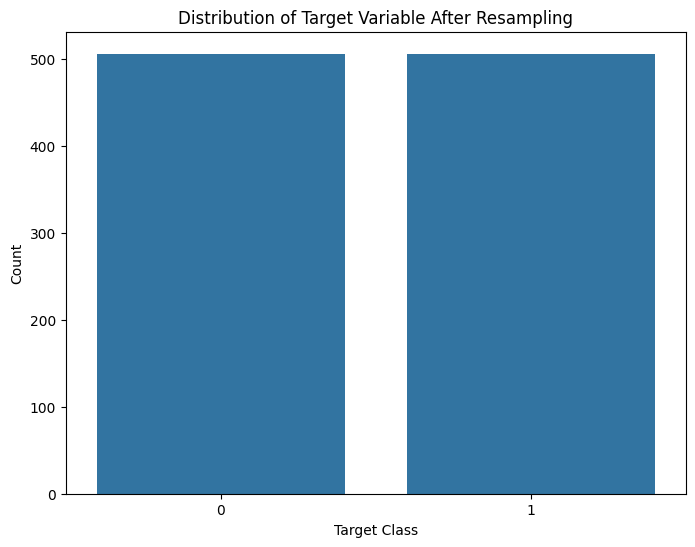

In [18]:

# Flatten the 2D array to 1D
target_resampled_flattened = target_resampled.values.ravel()

# Convert to Pandas Series
target_resampled_series = pd.Series(target_resampled_flattened)

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target_resampled_series)
plt.title('Distribution of Target Variable After Resampling')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.show()

In [19]:
display(features_train)

,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness
181,182,1,18,1,29.536862,Overweight,1,None-minimal,False,0,0,1,None-minimal,False,0,False,3.0,0
54,55,1,18,0,21.773842,Normal,6,Mild,False,0,0,5,Mild,False,0,False,11.0,1
734,735,4,22,0,22.718974,Normal,3,None-minimal,False,0,0,5,Mild,False,0,False,5.0,0
365,366,2,20,1,23.566632,Normal,3,None-minimal,False,0,0,8,Mild,False,0,False,5.0,0
97,98,1,18,0,25.636917,Overweight,6,Mild,False,0,0,3,None-minimal,False,0,False,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,72,1,19,1,26.446281,Overweight,5,Mild,False,0,0,4,None-minimal,False,0,False,1.0,0
106,107,1,19,1,26.555966,Overweight,5,Mild,False,0,0,4,None-minimal,False,0,False,2.0,0
270,271,1,22,1,26.234568,Overweight,5,Mild,False,0,0,3,None-minimal,False,0,False,5.0,0
435,436,2,21,1,26.234568,Overweight,8,Mild,False,0,1,6,Mild,False,0,False,0.0,0


## Data Preparation


### Datatype Transformation

It is done previous 

### Data Imputation

We apply the mean for the numerical values and KNN for the catergorical values

In [20]:

# Pipeline for the imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer


num_cols = ['school_year', 'age', 'gender', 'bmi', 'phq_score', 'depression_diagnosis', 'gad_score',
            'anxiety_diagnosis', 'epworth_score', 'sleepiness']

num_cols_no_pca = ['gender', 'bmi']

num_cols_pca = ['school_year', 'age', 'phq_score', 'depression_diagnosis', 'gad_score',
            'anxiety_diagnosis', 'epworth_score', 'sleepiness']

targets = ['anxiousness', 'depressiveness', 'treatment_status', 'suicidal']

cat_cols = ['who_bmi', 'depression_severity', 'anxiety_severity']





#cat_pipe = Pipeline(steps=[
#    ("imp", SimpleImputer(strategy="constant", fill_value="missing")),
#    ("ohe", OneHotEncoder(handle_unknown='ignore')),
#])


# Pipeline for categorical columns
cat_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),  # Simple Imputer for categorical data
    ("ohe", OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoding
])



#num_pipe = Pipeline(steps=[
#    ("imp", SimpleImputer(strategy="mean")),
#])

num_pipe = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('std_scaler', StandardScaler())
])




# Warnung vermeiden durch Kopieren des DataFrames, sher wichtig sonst funktioniert es nicht!
features_train = features_train.copy()
target_train = target_train.copy()


# Spalten-Transformator
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])

# Erstellen einer kompletten Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fitte die Pipeline auf die Trainingsdaten
features_train_transformed = pipeline.fit_transform(features_train)

# Transformiere die Testdaten
features_test_transformed = pipeline.transform(features_test)

# Ergebnisse anzeigen
print("Transformierte Trainingsdaten:\n", features_train_transformed)
print("Transformierte Testdaten:\n", features_test_transformed)


# Überprüfen auf NaN-Werte
print('Anzahl der NaN-Werte in den transformierten Trainingsdaten:', np.isnan(features_train_transformed).sum())
print('Anzahl der NaN-Werte in den transformierten Testdaten:', np.isnan(features_test_transformed).sum())



Transformierte Trainingsdaten:
 [[-1.10408888 -1.25448001  1.04143754 ...  0.          1.
   0.        ]
 [-1.10408888 -1.25448001 -0.96021121 ...  0.          0.
   0.        ]
 [ 1.46673675  0.99966376 -0.96021121 ...  0.          0.
   0.        ]
 ...
 [-1.10408888  0.99966376  1.04143754 ...  0.          1.
   0.        ]
 [-0.24714701  0.43612782  1.04143754 ...  0.          0.
   0.        ]
 [-1.10408888 -1.25448001 -0.96021121 ...  0.          0.
   0.        ]]
Transformierte Testdaten:
 [[ 0.60979487  0.43612782  1.04143754 ...  0.          1.
   0.        ]
 [ 0.60979487  0.43612782  1.04143754 ...  0.          1.
   0.        ]
 [-1.10408888  0.43612782  1.04143754 ...  0.          0.
   0.        ]
 ...
 [ 0.60979487  0.43612782  1.04143754 ...  0.          0.
   0.        ]
 [-0.24714701 -1.25448001 -0.96021121 ...  0.          0.
   0.        ]
 [-0.24714701 -0.69094407  1.04143754 ...  1.          0.
   0.        ]]
Anzahl der NaN-Werte in den transformierten Trainings

### Deal with outliers

* We decide to keep all the outliers, thea are important

Feature Engineering, see the paper:

https://www.kaggle.com/code/geovaniwoll/machine-learningproject

We apply the idea with a new feature:

# severity_index and phq_gad_relation 
df['severity_index'] = df['phq_score'] + df['gad_score']
df['phq_gad_relation'] = df['phq_score'] / df['gad_score']

# Polynomal features

We apply a new target (target-engineering), see:

df['treatment_status'] = df['depression_treatment'] | df['anxiety_treatment']


,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,suicidal,depression_diagnosis,...,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness,severity_index,phq_gad_relation,depressiveness
181,182,1,18,1,29.536862,Overweight,1,None-minimal,False,0,...,1,None-minimal,False,0,False,3.0,0,2,1.000,0
54,55,1,18,0,21.773842,Normal,6,Mild,False,0,...,5,Mild,False,0,False,11.0,1,11,1.200,0
734,735,4,22,0,22.718974,Normal,3,None-minimal,False,0,...,5,Mild,False,0,False,5.0,0,8,0.600,0
365,366,2,20,1,23.566632,Normal,3,None-minimal,False,0,...,8,Mild,False,0,False,5.0,0,11,0.375,0
97,98,1,18,0,25.636917,Overweight,6,Mild,False,0,...,3,None-minimal,False,0,False,1.0,0,9,2.000,0


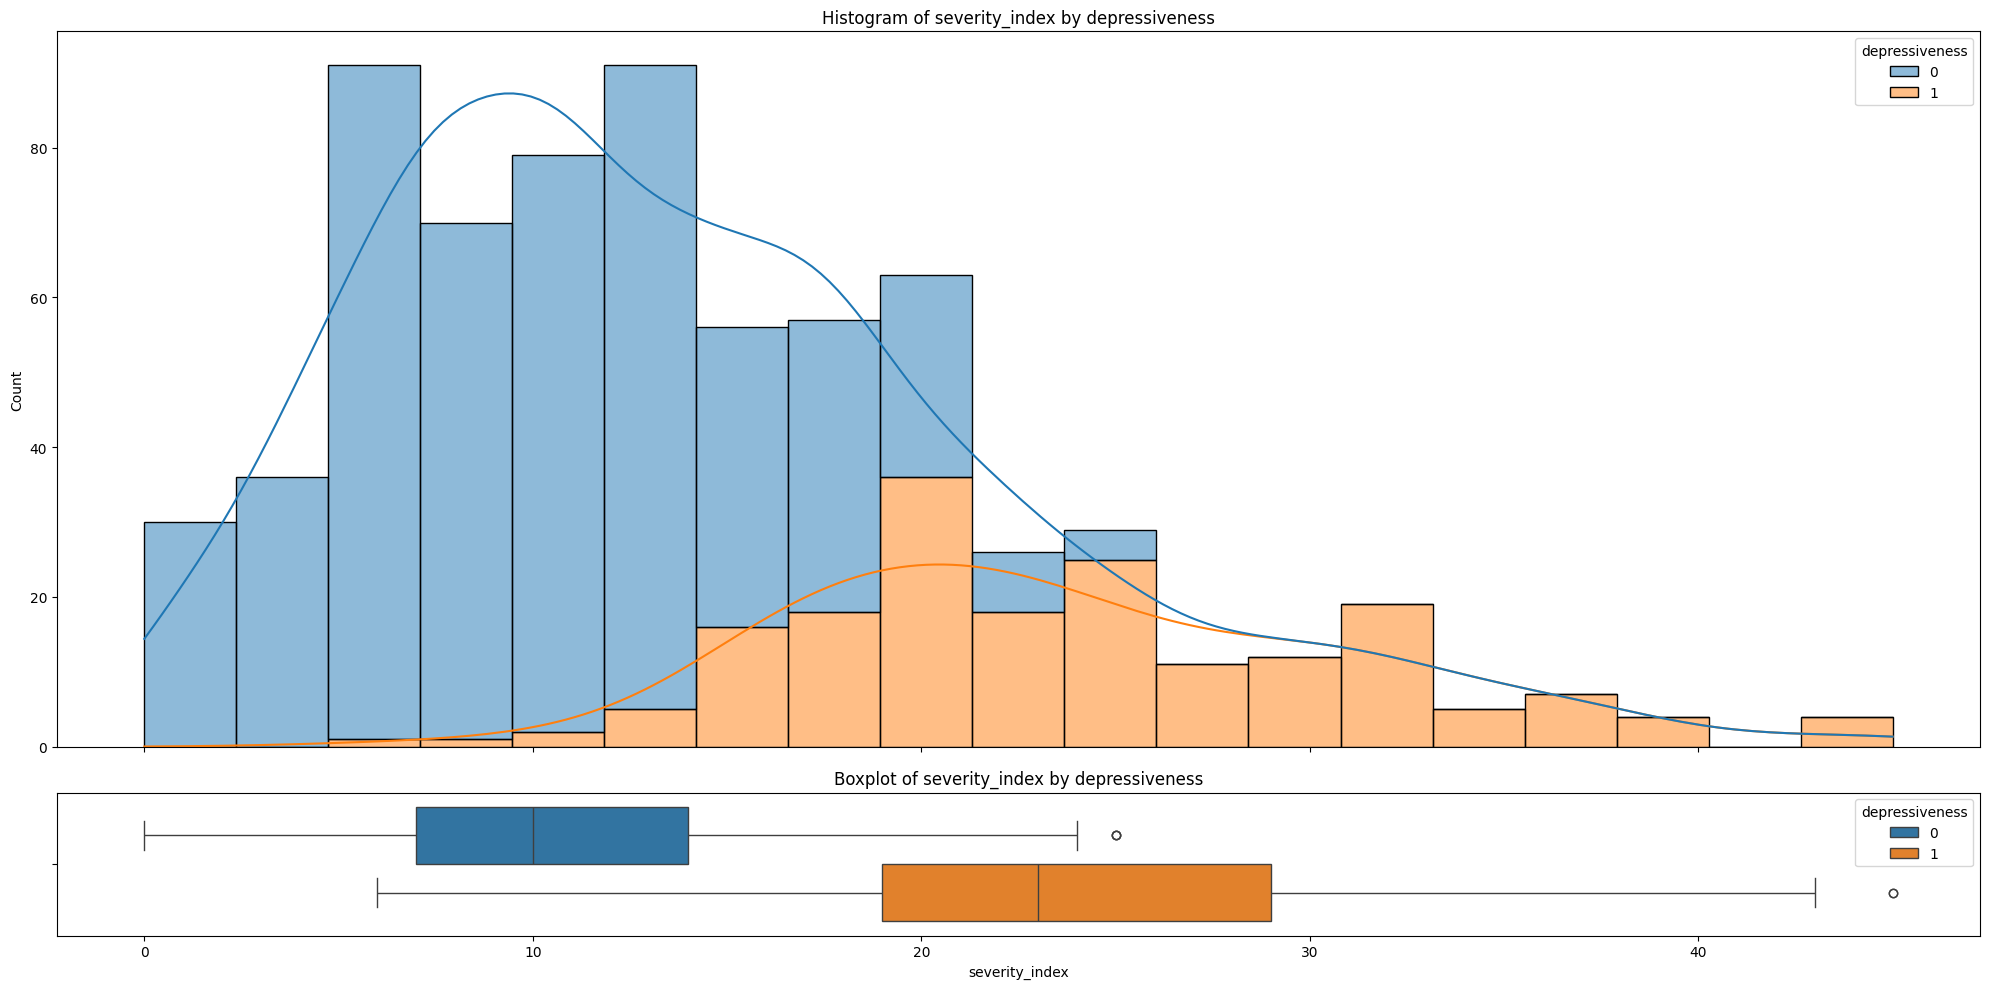

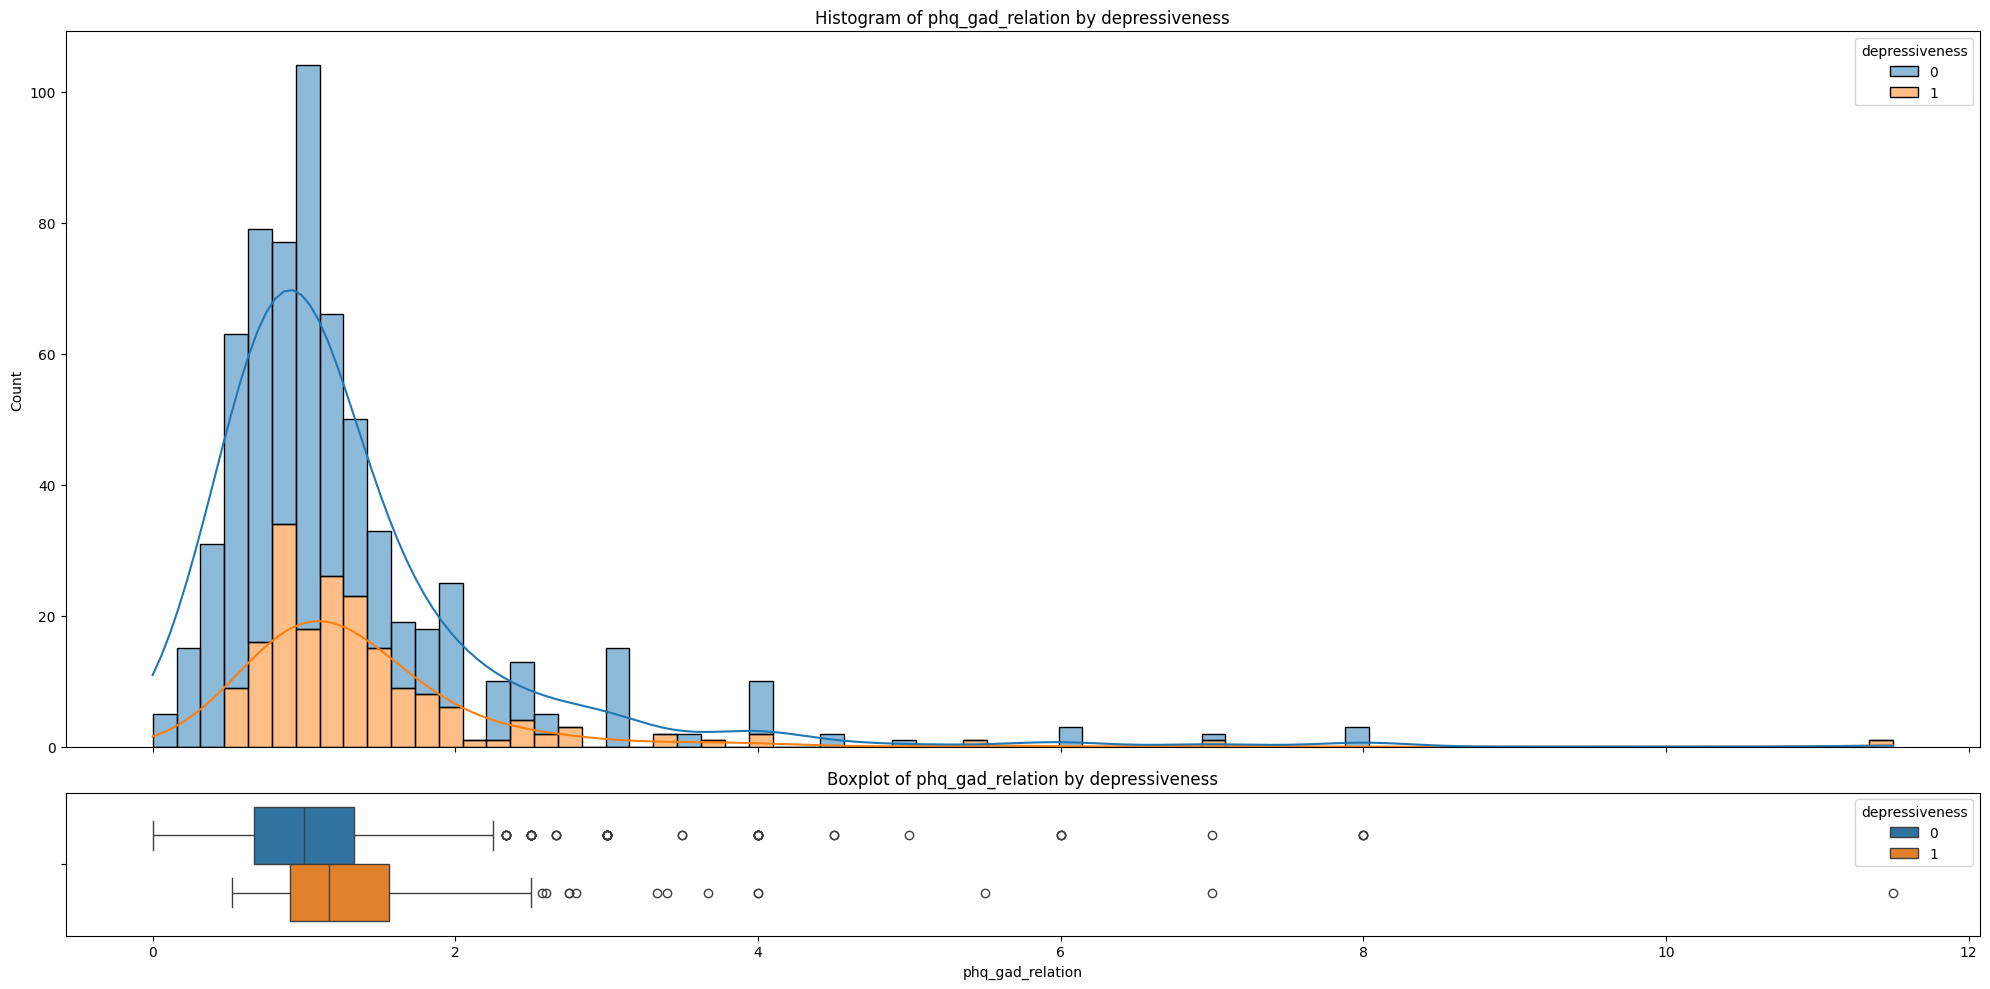

In [21]:
# Feature Engineering


features_train['severity_index'] = features_train['phq_score'] + features_train['gad_score']
features_train['phq_gad_relation'] = features_train['phq_score'] / features_train['gad_score']

df_mod = features_train.copy()

df_mod['depressiveness'] = target_train['depressiveness']

display(df_mod.head())


num_new_cols = ['severity_index', 'phq_gad_relation']

# Histogram and boxplot for the numerical features with the target "depressiveness" as Hue


# Histogram and boxplot for the numerical features with the target "depressiveness" as Hue
for col in num_new_cols:

    # Full plot histogram and boxplot
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [5, 1]})
    
    # Histogram
    sns.histplot(data=df_mod, x=col, hue='depressiveness', kde=True, multiple="stack", ax=axes[0])
    axes[0].set_title(f'Histogram of {col} by depressiveness')
    
    # Boxplot
    sns.boxplot(data=df_mod, x=col, hue='depressiveness', ax=axes[1])
    axes[1].set_title(f'Boxplot of {col} by depressiveness')

    # Titles of the axis
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()



In [22]:

# Optionally, you can check just the new features for NaNs
print("\nNumber of NaN values in the newly engineered features:")
print(features_train[['severity_index', 'phq_gad_relation']].isnull().sum())


Number of NaN values in the newly engineered features:
severity_index      0
phq_gad_relation    9
dtype: int64


In [23]:


# Feature Engineering

# Design new prosperous features



def engineer_features(X, y=None, inplace=False):
    if not inplace:
        X = X.copy()
        if y is not None:
            y = y.copy()

    X['severity_index'] = X['phq_score'] + X['gad_score']
    X['phq_gad_relation'] = X['phq_score'] / X['gad_score']
    
    if y is not None:
        return X, y
    else:
        return X
    
    



# Feature-Engineering auf train und test anwenden
features_train, target_train = engineer_features(features_train, target_train)
display(features_train)

features_test, target_test = engineer_features(features_test, target_test)
display(features_test)








,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness,severity_index,phq_gad_relation
181,182,1,18,1,29.536862,Overweight,1,None-minimal,False,0,0,1,None-minimal,False,0,False,3.0,0,2,1.000000
54,55,1,18,0,21.773842,Normal,6,Mild,False,0,0,5,Mild,False,0,False,11.0,1,11,1.200000
734,735,4,22,0,22.718974,Normal,3,None-minimal,False,0,0,5,Mild,False,0,False,5.0,0,8,0.600000
365,366,2,20,1,23.566632,Normal,3,None-minimal,False,0,0,8,Mild,False,0,False,5.0,0,11,0.375000
97,98,1,18,0,25.636917,Overweight,6,Mild,False,0,0,3,None-minimal,False,0,False,1.0,0,9,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,72,1,19,1,26.446281,Overweight,5,Mild,False,0,0,4,None-minimal,False,0,False,1.0,0,9,1.250000
106,107,1,19,1,26.555966,Overweight,5,Mild,False,0,0,4,None-minimal,False,0,False,2.0,0,9,1.250000
270,271,1,22,1,26.234568,Overweight,5,Mild,False,0,0,3,None-minimal,False,0,False,5.0,0,8,1.666667
435,436,2,21,1,26.234568,Overweight,8,Mild,False,0,1,6,Mild,False,0,False,0.0,0,14,1.333333


,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness,severity_index,phq_gad_relation
597,598,3,21,1,22.545959,Normal,4,None-minimal,False,0,0,0,None-minimal,False,0,False,8.0,0,4,inf
589,590,3,21,1,26.365603,Overweight,1,None-minimal,False,0,0,1,None-minimal,False,0,False,6.0,0,2,1.000000
208,209,1,21,1,24.897060,Normal,15,Moderately severe,False,0,1,5,Mild,False,0,False,1.0,0,20,3.000000
291,292,2,19,0,23.529412,Normal,19,Moderately severe,False,0,0,21,Severe,True,0,False,15.0,1,40,0.904762
174,175,1,20,1,24.814815,Normal,11,Moderate,False,0,0,10,Moderate,True,0,False,8.0,0,21,1.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,325,2,20,0,21.936347,Normal,5,Mild,False,0,0,9,Mild,False,0,False,4.0,0,14,0.555556
623,624,4,21,0,23.054562,Normal,11,Moderate,False,0,0,5,Mild,False,0,False,9.0,0,16,2.200000
591,592,3,21,1,25.401701,Overweight,9,Mild,False,0,0,7,Mild,False,0,False,11.0,1,16,1.285714
332,333,2,18,0,23.233456,Normal,6,Mild,False,0,0,7,Mild,False,0,False,2.0,0,13,0.857143


In [24]:
# Add the new features

display(features_train.head())



,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness,severity_index,phq_gad_relation
181,182,1,18,1,29.536862,Overweight,1,None-minimal,False,0,0,1,None-minimal,False,0,False,3.0,0,2,1.000
54,55,1,18,0,21.773842,Normal,6,Mild,False,0,0,5,Mild,False,0,False,11.0,1,11,1.200
734,735,4,22,0,22.718974,Normal,3,None-minimal,False,0,0,5,Mild,False,0,False,5.0,0,8,0.600
365,366,2,20,1,23.566632,Normal,3,None-minimal,False,0,0,8,Mild,False,0,False,5.0,0,11,0.375
97,98,1,18,0,25.636917,Overweight,6,Mild,False,0,0,3,None-minimal,False,0,False,1.0,0,9,2.000


In [25]:
# Function to clean with the outliers


def sampling_features(X, y=None, inplace=False):
    if not inplace:
        X = X.copy()
        if y is not None:
            y = y.copy()
 
    # Outliers, if necessary
#    if y is not None:
#        mask = X['epworth_score'] > 21
#        X = X[mask]
#        y = y[mask]
#        return X, y
#    else:
#        X = X[X['epworth_score'] > 21]
#        return X
    
    if y is not None:
        return X, y
    else:
        return X
    
    
    


### Resample

The imbalanced target is *resampling*, e.g. `imblearn.pipeline` 

In [26]:
# See also at the beginning:

print(target_resampled)
# Assuming target_resampled is a Pandas Series, check the balance
print(target_resampled.value_counts())

# Optionally, you can also print the proportion of each class
print(target_resampled.value_counts(normalize=True))


      depressiveness
0                  0
1                  0
2                  0
3                  0
4                  0
...              ...
1007               1
1008               1
1009               1
1010               1
1011               1

[1012 rows x 1 columns]
depressiveness
0                 506
1                 506
Name: count, dtype: int64
depressiveness
0                 0.5
1                 0.5
Name: proportion, dtype: float64


In [27]:
# to store the files with pickle (optional)

import pickle

state = {
    'features_train': features_train,
    'target_train': target_train,
    'features_test': features_test,
    'target_test': target_test,    
}
# Dictionary speichern:
with open('state.pkl', 'wb') as f:
    pickle.dump(state, f)


In [28]:

# Reopen the stored pickl-files (optional):
import pickle

with open('state.pkl', 'rb') as f:
    state = pickle.load(f)

features_train = state['features_train']
target_train = state['target_train']

features_test = state['features_test']
target_test = state['target_test']


#rf_pipe = state['rf_pipe']

In [29]:
display(features_train)

display(features_train.dtypes)

display(target_train)

display(target_train.dtypes)



,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness,severity_index,phq_gad_relation
181,182,1,18,1,29.536862,Overweight,1,None-minimal,False,0,0,1,None-minimal,False,0,False,3.0,0,2,1.000000
54,55,1,18,0,21.773842,Normal,6,Mild,False,0,0,5,Mild,False,0,False,11.0,1,11,1.200000
734,735,4,22,0,22.718974,Normal,3,None-minimal,False,0,0,5,Mild,False,0,False,5.0,0,8,0.600000
365,366,2,20,1,23.566632,Normal,3,None-minimal,False,0,0,8,Mild,False,0,False,5.0,0,11,0.375000
97,98,1,18,0,25.636917,Overweight,6,Mild,False,0,0,3,None-minimal,False,0,False,1.0,0,9,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,72,1,19,1,26.446281,Overweight,5,Mild,False,0,0,4,None-minimal,False,0,False,1.0,0,9,1.250000
106,107,1,19,1,26.555966,Overweight,5,Mild,False,0,0,4,None-minimal,False,0,False,2.0,0,9,1.250000
270,271,1,22,1,26.234568,Overweight,5,Mild,False,0,0,3,None-minimal,False,0,False,5.0,0,8,1.666667
435,436,2,21,1,26.234568,Overweight,8,Mild,False,0,1,6,Mild,False,0,False,0.0,0,14,1.333333


id                        int64
school_year               int64
age                       int64
gender                    int32
bmi                     float64
who_bmi                  object
phq_score                 int64
depression_severity      object
suicidal                 object
depression_diagnosis      int32
depression_treatment      int32
gad_score                 int64
anxiety_severity         object
anxiousness              object
anxiety_diagnosis         int32
anxiety_treatment        object
epworth_score           float64
sleepiness                int32
severity_index            int64
phq_gad_relation        float64
dtype: object

,depressiveness
181,0
54,0
734,0
365,0
97,0
...,...
71,0
106,0
270,0
435,0


depressiveness    int32
dtype: object

## Modeling

Here we apply the different models

In [30]:

# Installation of the TargetEncoder for the categorial columns

!pip install category_encoders
import category_encoders as ce


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Trainee\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [31]:
display(features_train.head(2))
display(features_test.head(2))

,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness,severity_index,phq_gad_relation
181,182,1,18,1,29.536862,Overweight,1,None-minimal,False,0,0,1,None-minimal,False,0,False,3.0,0,2,1.0
54,55,1,18,0,21.773842,Normal,6,Mild,False,0,0,5,Mild,False,0,False,11.0,1,11,1.2


,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness,severity_index,phq_gad_relation
597,598,3,21,1,22.545959,Normal,4,None-minimal,False,0,0,0,None-minimal,False,0,False,8.0,0,4,inf
589,590,3,21,1,26.365603,Overweight,1,None-minimal,False,0,0,1,None-minimal,False,0,False,6.0,0,2,1.0


In [32]:
# define num_cols and cat_cols for the depressiveness

# Important Columns and their relation, e.g., for the PCA

#num_cols = ['school_year', 'age', 'gender', 'bmi', 'phq_score', 'depression_diagnosis', 'gad_score',
#            'anxiety_diagnosis', 'epworth_score', 'sleepiness']


num_new_features = ['severity_index']  # delicate while NaN , 'phq_gad_relation']

num_cols = ['school_year', 'age', 'gender', 'bmi', 'gad_score',
            'anxiety_diagnosis', 'epworth_score', 'sleepiness']

num_cols = num_cols + num_new_features    #  add the new features to the old ones


num_cols_no_pca = ['gender', 'bmi']

num_cols_pca = ['school_year', 'age', 'depression_diagnosis', 'gad_score',
            'anxiety_diagnosis', 'epworth_score', 'sleepiness']

targets = ['anxiousness', 'depressiveness', 'treatment_status', 'suicidal']

# (depression_treatment and anxiety_treatment  are columns, which are used in the target treatment_status)

#cat_cols = ['who_bmi', 'depression_severity', 'anxiety_severity']
cat_cols = ['who_bmi', 'anxiety_severity']

target = ['depressiveness']



In [33]:
# instantiate model

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier





In [34]:


from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

cat_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value="missing")),
    ("target_enc", ce.TargetEncoder())  # TargetEncoder hinzufügen
#    ("ohe", OneHotEncoder(handle_unknown='ignore')),  # One-Hot encoder
])

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="mean")),
#    ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # PolynomialFeatures hinzufügen, bringt nichts, da man
#    Lineare Kombinationen hat
    ("scaler", StandardScaler()),
])


preprocessing = ColumnTransformer(
    transformers=[
        ("num_trans", num_pipe, num_cols),
        ("cat_trans", cat_pipe, cat_cols),
    ],
    remainder = "drop",
)


rf_pipe = ImbPipeline(steps=[
    ("oversampler", RandomOverSampler()),   # Hinzufügen des RandomOverSamplers
    ("pre", preprocessing),
    ("kbest", SelectKBest(k=10, score_func=f_classif)),
    ("model", RandomForestClassifier()),
#    ("model", RandomForestClassifier_mod()),
])


In [35]:
# fit pipeline on cleaned (and filtered) training set

rf_pipe.fit(features_train, target_train)

C:\Users\Trainee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Trainee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['school_year', 'age',
                                                   'gender', 'bmi', 'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score',
                                                   'sleepiness',
                                                   'severity_index']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('target_enc',
                                                                   TargetEncoder())]),
                                                  ['who_bmi',
                                                   'anxiety_severity'])])),
                ('kbest', SelectKBest()), ('model', RandomForestClassifier())])

In [36]:
# predict and evaluate on test set

print(classification_report(target_test, rf_pipe.predict(features_test)))






              precision    recall  f1-score   support

           0       0.91      0.98      0.95        54
           1       0.94      0.76      0.84        21

    accuracy                           0.92        75
   macro avg       0.93      0.87      0.89        75
weighted avg       0.92      0.92      0.92        75



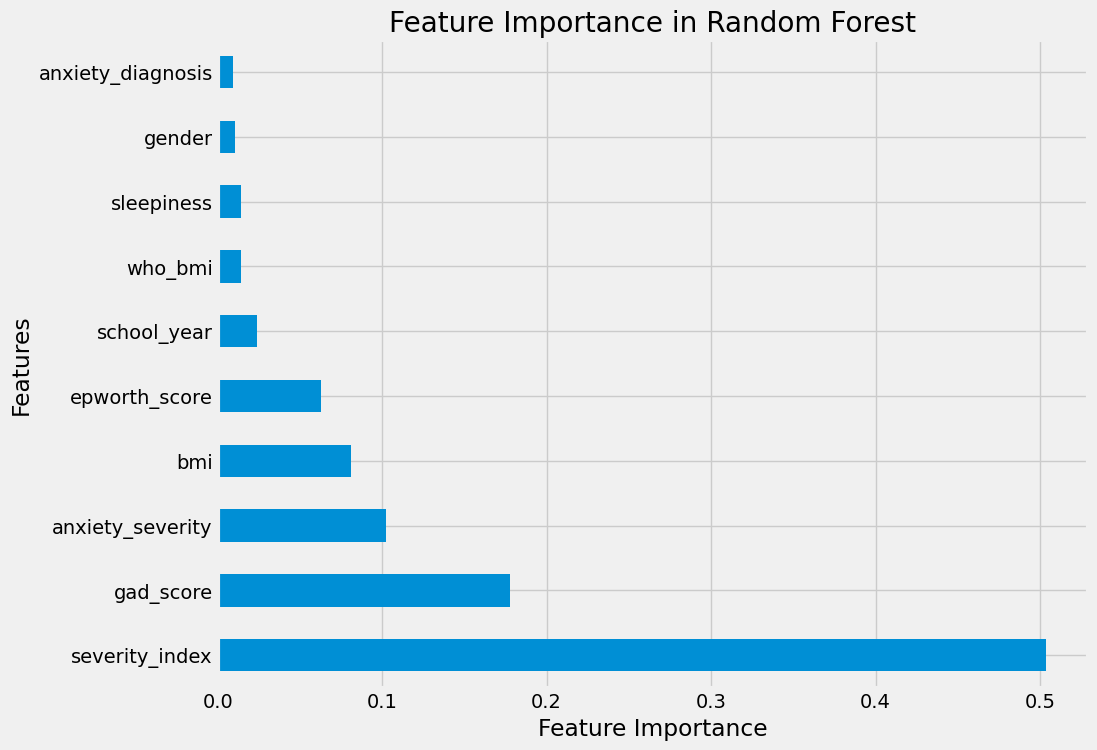

In [37]:


# Feature Importance ermitteln
rf_model = rf_pipe.named_steps['model']

# Extrahieren der Feature-Namen nach der Transformation
preprocessor = rf_pipe.named_steps['pre']
kbest = rf_pipe.named_steps['kbest']
selected_features = kbest.get_support(indices=True)

# Numerische und kategorische Feature-Namen nach der Transformation
num_feature_names = num_cols
cat_feature_names = cat_cols

# Kombinierte Liste der ursprünglichen Features
all_features = num_feature_names + cat_feature_names

# Ausgewählte Features nach SelectKBest
selected_feature_names = [all_features[i] for i in selected_features]

# Erzeuge eine Serie mit den Feature Importances
feature_importance_rf = pd.Series(rf_model.feature_importances_, index=selected_feature_names)

# Sortiere die Werte und wähle die Top 10 Features aus
top_10_features = feature_importance_rf.nlargest(10)

# Erzeuge ein Balkendiagramm
plt.style.use('fivethirtyeight')
top_10_features.plot(kind='barh', figsize=(10, 8))

# Füge Beschriftungen hinzu
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')

# Zeige das Diagramm an
plt.show()


### Data Scaling

This is done with the standardscalar

### Dimensionality Reduction

Here, we apply the knowledge of the previous EDA and PowerBI:

    all organic  (age, gender, etc)

    BMI and EpScore (OR the who_bmi and Sleepiness classification columns) 

    Anxiety (GAD score OR anxiety severity OR anxiousness) 

    Anxiety diagnosis OR treatment 

    Depression diagnosis OR treatment (since independent of the test)

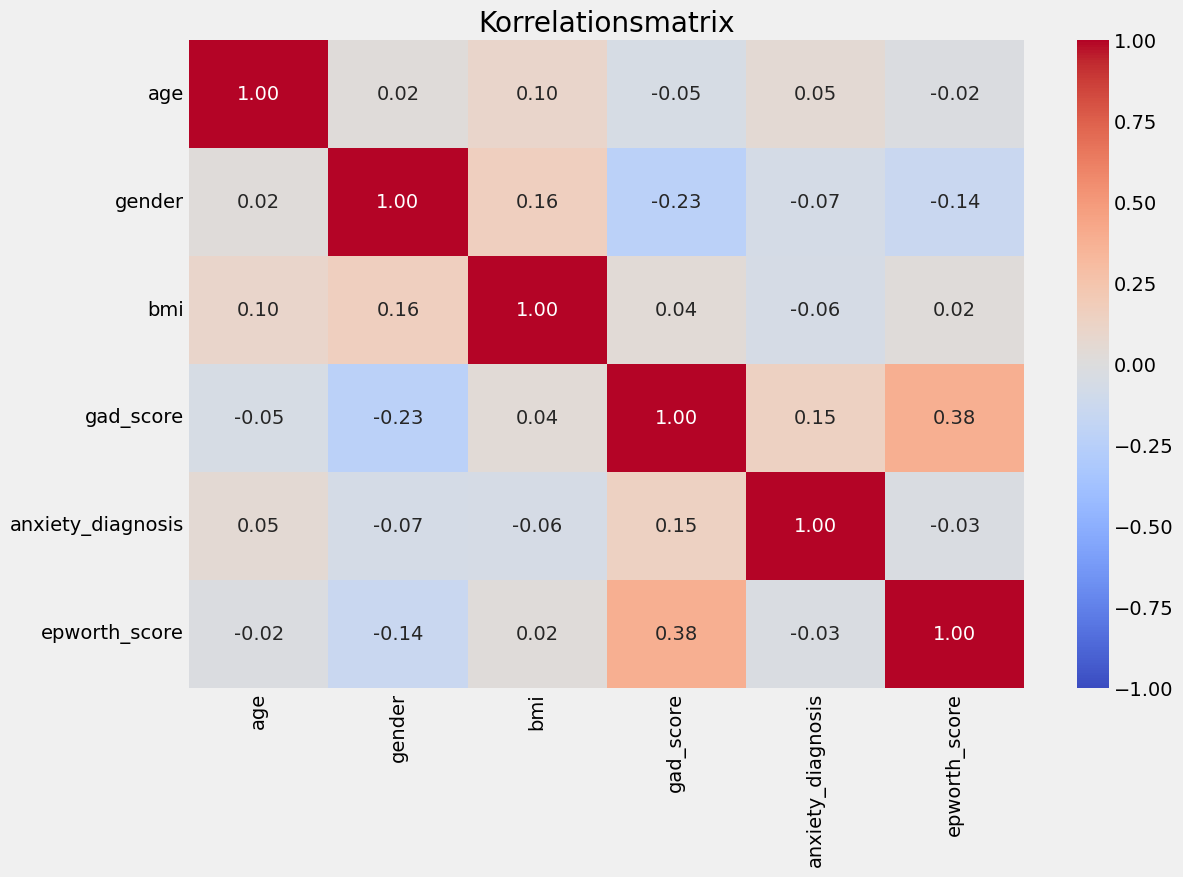

In [38]:
# Mache ich in der Pipeline



num_new_features = ['severity_index']  # delicate while NaN , 'phq_gad_relation']  They are to related, while phd_score

#num_cols = ['age', 'gender', 'gad_score', 'anxiousness',
#            'anxiety_diagnosis', 'epworth_score', 'sleepiness']

num_cols = ['age', 'gender', 'bmi', 'gad_score',
            'anxiety_diagnosis', 'epworth_score']


num_cols_no_pca = ['gender', 'bmi']

num_cols_pca = ['school_year', 'age', 'depression_diagnosis', 'gad_score',
            'anxiety_diagnosis', 'epworth_score', 'sleepiness']


# (depression_treatment and anxiety_treatment  are columns, which are used in the target treatment_status)

#cat_cols = ['who_bmi', 'depression_severity', 'anxiety_severity']
cat_cols = ['who_bmi']

target = ['depressiveness']


# Korrelationsmatrix
corr_matrix = features_train[num_cols].corr()

# Heatmap der Korrelationsmatrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin = -1, vmax = 1, fmt='.2f')
plt.title('Korrelationsmatrix')
plt.show()


### Train model

In [39]:
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [40]:
#useful imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report

Here, we built the pipelines:

In [41]:
cat_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value="missing")),
#   ("ohe", OneHotEncoder(handle_unknown='ignore')),
    ("target_enc", ce.TargetEncoder()),  # TargetEncoder hinzufügen    
])

# Macht hier mehr Sinn
num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="mean")),
#    ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # PolynomialFeatures hinzufügen
    ("scaler", StandardScaler()),

])



# Pipeline für numerische Daten mit PCA
num_pipe_pca = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
#    ("pca", PCA(n_components=0.90))  # 90% der Varianz beibehalten
])



In [42]:
# build unoptimized model, Random forest
num_cols = ['age', 'gender', 'bmi', 'gad_score',
            'anxiety_diagnosis', 'epworth_score']


cat_cols = ['who_bmi']

target = ['depressiveness']




preprocessing_rf = ColumnTransformer(
    transformers=[
        ("num_trans", num_pipe, num_cols),
#        ("num_pca", num_pipe_pca, num_cols_pca),
        ("cat_trans", cat_pipe, cat_cols)
    ],
    remainder="drop"
)

# PolynomialFeatures hinzufügen
# poly_features = PolynomialFeatures(degree=2, include_bias=False)


rf_pipe_pca = ImbPipeline(steps=[
    ("oversampler", RandomOverSampler()),   # Hinzufügen des RandomOverSamplers oder Rausnehmen!!! Aufpassen am Ende!!!
    ("pre", preprocessing_rf),
#    ("kbest", SelectKBest(k=10, score_func=f_classif)),
    ("model", RandomForestClassifier()),
])




print(rf_pipe_pca)


Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'gender', 'bmi',
                                                   'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
              

In [43]:
# fit pipeline on cleaned (and filtered) training set

rf_pipe_pca.fit(features_train, target_train)

Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'gender', 'bmi',
                                                   'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('target_enc',
                                                                   TargetEncoder())]),
                                                  ['who_bmi'])])),
                ('model', RandomForestClassifier())])

In [44]:

#display(features_train)
print(classification_report(target_test, rf_pipe_pca.predict(features_test)))



              precision    recall  f1-score   support

           0       0.83      0.91      0.87        54
           1       0.69      0.52      0.59        21

    accuracy                           0.80        75
   macro avg       0.76      0.72      0.73        75
weighted avg       0.79      0.80      0.79        75



In [45]:
# Modell 2:
# logistic regression


preprocessing_log = ColumnTransformer(
    transformers=[
        ("num_trans", num_pipe, num_cols),
#        ("num_pca", num_pipe_pca, num_cols_pca),
        ("cat_trans", cat_pipe, cat_cols)
    ],
    remainder="drop"
)

# PolynomialFeatures hinzufügen
# poly_features = PolynomialFeatures(degree=2, include_bias=False)


log_pipe_pca = ImbPipeline(steps=[
#    ("pre", preprocessing_rf),
    ("oversampler", RandomOverSampler()),   # Hinzufügen des RandomOverSamplers oder Rausnehmen!!! Aufpassen am Ende!!!
    ("pre", preprocessing_log),
#    ("poly", poly_features),   # später ausprobieren, bringt es nicht mehr
#    ("kbest", SelectKBest(k=10, score_func=f_classif)),
#    ("model", LogisticRegression(max_iter=1000))
    ("model", LogisticRegression(max_iter=5000))    
])


print(log_pipe_pca)





Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'gender', 'bmi',
                                                   'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
              

In [46]:
# fit pipeline on cleaned (and filtered) training set

log_pipe_pca.fit(features_train, target_train)

Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'gender', 'bmi',
                                                   'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('target_enc',
                                                                   TargetEncoder())]),
                                                  ['who_bmi'])])),
                ('model', LogisticRegression(max_iter=5000))])

In [47]:
# predict and evaluate on test set
# Auf dem Testset die Feature-Engineering anwenden)
#
#display(target_test)
#display(features_test)

#display(features_train)
print(classification_report(target_test, log_pipe_pca.predict(features_test)))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89        54
           1       0.74      0.67      0.70        21

    accuracy                           0.84        75
   macro avg       0.81      0.79      0.80        75
weighted avg       0.84      0.84      0.84        75



In [48]:
# Model 3: KNN


preprocessing_knn = ColumnTransformer(
    transformers=[
        ("num_trans", num_pipe, num_cols),
        ("num_pca", num_pipe_pca, num_cols_pca),
        ("cat_trans", cat_pipe, cat_cols)
    ],
    remainder="drop"
)

# PolynomialFeatures hinzufügen
# poly_features = PolynomialFeatures(degree=2, include_bias=False)


knn_pipe_pca = ImbPipeline(steps=[
#    ("pre", preprocessing_rf),
    ("oversampler", RandomOverSampler()),   # Hinzufügen des RandomOverSamplers oder Rausnehmen!!! Aufpassen am Ende!!!
    ("pre", preprocessing_knn),
#    ("poly", poly_features),   # später ausprobieren, bringt es nicht mehr
#    ("kbest", SelectKBest(k=10, score_func=f_classif)),
    ("model", KNeighborsClassifier())
])


print(knn_pipe_pca)


Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'gender', 'bmi',
                                                   'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score']),
                                                 ('num_pca',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                  

In [49]:
# fit it

knn_pipe_pca.fit(features_train, target_train)

Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'gender', 'bmi',
                                                   'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score']),
                                                 ('num_pca',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['school_year', 'age',
                                                   'depression_diagnosis',
                                                   'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score',
                                                   'sleepiness']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('target_enc',
                                                                   TargetEncoder())]),
                                                  ['who_bmi'])])),
                ('model', KNeighborsClassifier())])

In [50]:

#display(features_train)
print(classification_report(target_test, knn_pipe_pca.predict(features_test)))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        54
           1       0.65      0.71      0.68        21

    accuracy                           0.81        75
   macro avg       0.77      0.78      0.77        75
weighted avg       0.82      0.81      0.82        75



In [51]:
# Model 4: Decision Tree


preprocessing_dec = ColumnTransformer(
    transformers=[
        ("num_trans", num_pipe, num_cols),
#        ("num_pca", num_pipe_pca, num_cols_pca),
        ("cat_trans", cat_pipe, cat_cols)
    ],
    remainder="drop"
)

# PolynomialFeatures hinzufügen
# poly_features = PolynomialFeatures(degree=2, include_bias=False)


dec_pipe_pca = ImbPipeline(steps=[
#    ("pre", preprocessing_rf),
    ("oversampler", RandomOverSampler()),   # Hinzufügen des RandomOverSamplers oder Rausnehmen!!! Aufpassen am Ende!!!
    ("pre", preprocessing_dec),
#    ("poly", poly_features),   # später ausprobieren, bringt es nicht mehr
#    ("kbest", SelectKBest(k=10, score_func=f_classif)),
    ("model", DecisionTreeClassifier()),
])


print(dec_pipe_pca)


Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'gender', 'bmi',
                                                   'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
              

In [52]:
# fit pipeline on cleaned (and filtered) training set

dec_pipe_pca.fit(features_train, target_train)

Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'gender', 'bmi',
                                                   'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('target_enc',
                                                                   TargetEncoder())]),
                                                  ['who_bmi'])])),
                ('model', DecisionTreeClassifier())])

In [53]:

#display(features_train)
print(classification_report(target_test, dec_pipe_pca.predict(features_test)))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        54
           1       0.63      0.57      0.60        21

    accuracy                           0.79        75
   macro avg       0.74      0.72      0.73        75
weighted avg       0.78      0.79      0.78        75



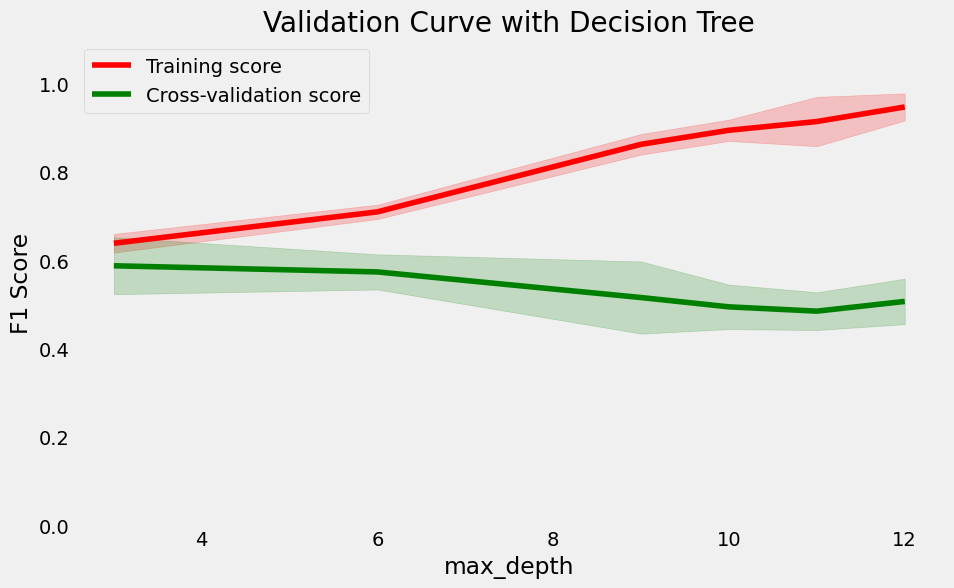

   max_depth  Training F1-score  Validation F1-score
0          3           0.639010             0.588064
1          6           0.710078             0.574127
2          9           0.862943             0.516131
3         10           0.894717             0.495072
4         11           0.914545             0.485357
5         12           0.947470             0.507384


In [54]:
# Cross-Validation Curve zum Sichtbarmachung der Lernens

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve


# Definiere die Tiefe des Baums, die getestet werden soll
depth = [3, 6, 9, 10, 11, 12] # , 13, 14, 15, 18, 21]

# Berechne die Validierungskurve
train_scores, test_scores = validation_curve(
    estimator=dec_pipe_pca, # Die Pipeline
    X=features_train, # Merkmalsmatrix
    y=target_train, # Zielvektor
    param_name='model__max_depth', # Hyperparameter des DecisionTreeClassifiers innerhalb der Pipeline
    param_range=depth, # Werte des Hyperparameters
    cv=5, # 5-fache Kreuzvalidierung
    scoring='f1', # F1-Score zur Bewertung
    n_jobs=-1 # Alle verfügbaren Kerne verwenden, um zu beschleunigen
)

# Mittelwert und Standardabweichung der Trainings- und Test-Scores berechnen
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Visualisiere die Validierungskurve
plt.figure(figsize=(10, 6))
plt.title('Validation Curve with Decision Tree')
plt.xlabel('max_depth')
plt.ylabel('F1 Score')
plt.ylim(0.0, 1.1)

# Fehlerbalken für Trainingsscores
plt.plot(depth, train_scores_mean, label='Training score', color='r')
plt.fill_between(depth, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='r')

# Fehlerbalken für Testscores
plt.plot(depth, test_scores_mean, label='Cross-validation score', color='g')
plt.fill_between(depth, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='g')

plt.legend(loc='best')
plt.grid()
plt.show()

# F1-Scores in einem DataFrame anzeigen
F1 = pd.DataFrame({
    'max_depth': depth,
    'Training F1-score': train_scores_mean,
    'Validation F1-score': test_scores_mean
})
print(F1)

In [55]:

# Klassifikationsberichte erstellen
dec_report = classification_report(target_test, dec_pipe_pca.predict(features_test), output_dict=True)
knn_report = classification_report(target_test, knn_pipe_pca.predict(features_test), output_dict=True)
log_report = classification_report(target_test, log_pipe_pca.predict(features_test), output_dict=True)
rf_report = classification_report(target_test, rf_pipe_pca.predict(features_test), output_dict=True)

# Funktion zum Extrahieren der Metriken aus dem Bericht
def extract_metrics(report, model_name):
    metrics = []
    for key in ['0', '1', 'weighted avg']:
        precision = report[key]['precision']
        recall = report[key]['recall']
        f1_score = report[key]['f1-score']
        metrics.append({
            'Model': model_name,
            'Class': key,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score
        })
    return metrics

# Extrahiere die Metriken für alle Modelle
all_metrics = []
all_metrics.extend(extract_metrics(dec_report, 'Decision Tree'))
all_metrics.extend(extract_metrics(knn_report, 'KNN'))
all_metrics.extend(extract_metrics(log_report, 'Logistic Regression'))
all_metrics.extend(extract_metrics(rf_report, 'Random Forest'))

# Erstelle einen DataFrame
metrics_df = pd.DataFrame(all_metrics)

# Ausgabe der Tabelle
print(metrics_df)

                  Model         Class  Precision    Recall  F1 Score
0         Decision Tree             0   0.839286  0.870370  0.854545
1         Decision Tree             1   0.631579  0.571429  0.600000
2         Decision Tree  weighted avg   0.781128  0.786667  0.783273
3                   KNN             0   0.884615  0.851852  0.867925
4                   KNN             1   0.652174  0.714286  0.681818
5                   KNN  weighted avg   0.819532  0.813333  0.815815
6   Logistic Regression             0   0.875000  0.907407  0.890909
7   Logistic Regression             1   0.736842  0.666667  0.700000
8   Logistic Regression  weighted avg   0.836316  0.840000  0.837455
9         Random Forest             0   0.830508  0.907407  0.867257
10        Random Forest             1   0.687500  0.523810  0.594595
11        Random Forest  weighted avg   0.790466  0.800000  0.790911


In [56]:

# Finde das Modell mit dem höchsten F1-Score für die Klasse '1'
best_model_row = metrics_df[metrics_df['Class'] == '1'].sort_values(by='F1 Score', ascending=False).iloc[0]
best_model_name = best_model_row['Model']

# Abspeichern des besten Modells
if best_model_name == 'Decision Tree':
    best_model = dec_pipe_pca
elif best_model_name == 'KNN':
    best_model = knn_pipe_pca
elif best_model_name == 'Logistic Regression':
    best_model = log_pipe_pca
elif best_model_name == 'Random Forest':
    best_model = rf_pipe_pca

print(f"The best model is: {best_model_name} with F1 Score: {best_model_row['F1 Score']}")

The best model is: Logistic Regression with F1 Score: 0.7


In [57]:
# Wir haben die besten Modelle:

#                  Model         Class  Precision    Recall  F1 Score
#0         Decision Tree             0   0.482201  0.420174  0.449055
#1         Decision Tree             1   0.466680  0.529305  0.496024
#2         Decision Tree  weighted avg   0.474604  0.473585  0.472043
#3                   KNN             0   0.524940  0.518221  0.521559
#4                   KNN             1   0.504020  0.510749  0.507362
#5                   KNN  weighted avg   0.514701  0.514564  0.514611
#6   Logistic Regression             0   0.552378  0.410629  0.471071
#7   Logistic Regression             1   0.514995  0.652863  0.575791
#8   Logistic Regression  weighted avg   0.534082  0.529184  0.522323
#9         Random Forest             0   0.484709  0.388503  0.431306
#10        Random Forest             1   0.471504  0.569133  0.515739
#11        Random Forest  weighted avg   0.478246  0.476908  0.472630

In [58]:
# Optimation of the logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Parameter Grid definieren
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],  # Regularisierungsparameter
    'model__solver': ['newton-cg', 'lbfgs', 'sag'],
#    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # wäre noch bei L1 angesagt
    'model__penalty': ['l2'],  # L2-Regularisierung
}

# Logistic Regression Pipeline
log_pipe_pca = ImbPipeline(steps=[
    ("oversampler", RandomOverSampler()),  # Hinzufügen des RandomOverSamplers
    ("pre", preprocessing_log),
    ("model", LogisticRegression(max_iter=5000))  # Erhöhen der maximalen Iterationen
])

# GridSearchCV durchführen

# 'recall' ev. dann optimiert man den Recall!
grid_search_log = GridSearchCV(log_pipe_pca, param_grid, cv=5, scoring='f1', n_jobs=-1)
#grid_search_log = GridSearchCV(log_pipe_pca, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search_log.fit(features_train, target_train)

# Beste Parameter und Ergebnis anzeigen
print(f'Best parameters: {grid_search_log.best_params_}')
print(f'Best score: {grid_search_log.best_score_}')

Best parameters: {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best score: 0.6335637936570865


In [59]:
# Logistic Regression

# Best parameters: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
# Best score: 0.6569004829134826
#                 precision    recall  f1-score   support
#           0       0.93      0.78      0.85      5716
#           1       0.28      0.59      0.38       846


# Das beste Modell speichern
best_model_log = grid_search_log.best_estimator_

print(f'The best model in logistic regression is {best_model_log}.')

The best model in logistic regression is Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'gender', 'bmi',
                                                   'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImp

In [60]:
# Klassifikationsbericht für die Testdaten für das beste log. Regression Modell
print(classification_report(target_test, grid_search_log.predict(features_test)))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        54
           1       0.65      0.62      0.63        21

    accuracy                           0.80        75
   macro avg       0.75      0.74      0.75        75
weighted avg       0.80      0.80      0.80        75



In [61]:
# Optimation of Random-forest


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier



# Parameter Grid definieren
param_grid = {
    'model__n_estimators': [100] , # , 200],  # , 300],
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': [10, 20],  # , 30, None],
    'model__min_samples_split': [2, 5],  # , 10],
    'model__min_samples_leaf': [2, 4],  # [1, 2, 4]
}

# GridSearchCV durchführen # opimise the model after precision
grid_search_rf = GridSearchCV(rf_pipe_pca, param_grid, cv=5, scoring='f1', n_jobs=-1)
#grid_search_rf = GridSearchCV(rf_pipe_pca, param_grid, cv=5, scoring='precision', n_jobs=-1)
grid_search_rf.fit(features_train, target_train)

# Beste Parameter und Ergebnis anzeigen
print(f'Best parameters: {grid_search_rf.best_params_}')
print(f'Best score: {grid_search_rf.best_score_}')


Best parameters: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best score: 0.5968283162935188


In [62]:
# Klassifikationsbericht für die Testdaten
print(classification_report(target_test, grid_search_rf.predict(features_test)))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        54
           1       0.64      0.67      0.65        21

    accuracy                           0.80        75
   macro avg       0.75      0.76      0.76        75
weighted avg       0.80      0.80      0.80        75



In [63]:
# Best f1-score:
#           precision    recall  f1-score   support
#           0             0.90      0.96      0.93      5716
#           1             0.51      0.29      0.37       846    
  
#Best parameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}
#Best score: 0.836644589933015    
 


# Das beste Modell speichern
best_model_rf = grid_search_rf.best_estimator_

print(f'The best model in Random Forest is {best_model_rf}.')
 


The best model in Random Forest is Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'gender', 'bmi',
                                                   'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(f

In [64]:
# Optimation of KNN


# Define the parameter grid for KNN
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
    'model__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'model__metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric to use
}

# Set up GridSearchCV for the KNN pipeline
grid_search_knn = GridSearchCV(knn_pipe_pca, param_grid_knn, cv=5, scoring='f1', n_jobs=-1)

# Fit the GridSearchCV
grid_search_knn.fit(features_train, target_train)

# Display the best parameters and score
print(f'Best parameters for KNN: {grid_search_knn.best_params_}')
print(f'Best score for KNN: {grid_search_knn.best_score_}')

Best parameters for KNN: {'model__metric': 'euclidean', 'model__n_neighbors': 9, 'model__weights': 'distance'}
Best score for KNN: 0.572398383123225


In [65]:
# clssification-report of the KNN model

print(classification_report(target_test, grid_search_knn.predict(features_test)))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        54
           1       0.65      0.71      0.68        21

    accuracy                           0.81        75
   macro avg       0.77      0.78      0.77        75
weighted avg       0.82      0.81      0.82        75



### Model selection

Wähle das beste Modell aus. Entscheide dabei selbst, welche Metrik dir am wichtigsten ist. Mit `confusion_matrix()` aus `sklearn.metrics` kannst du genau sehen, wie viele Datenpunkte jeweils richtig und falsch klassifiziert wurden. Vielleicht hilft dir das bei deiner Entscheidung.

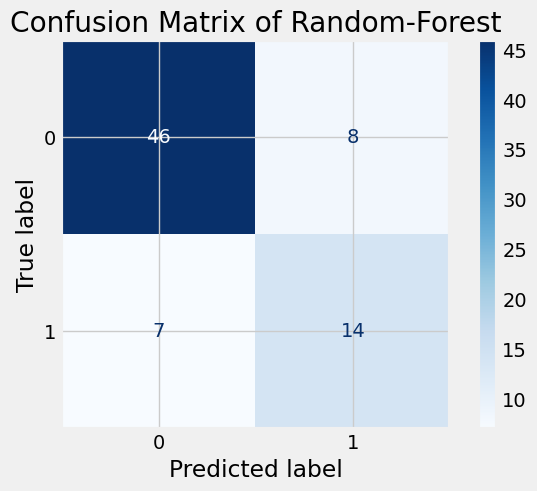

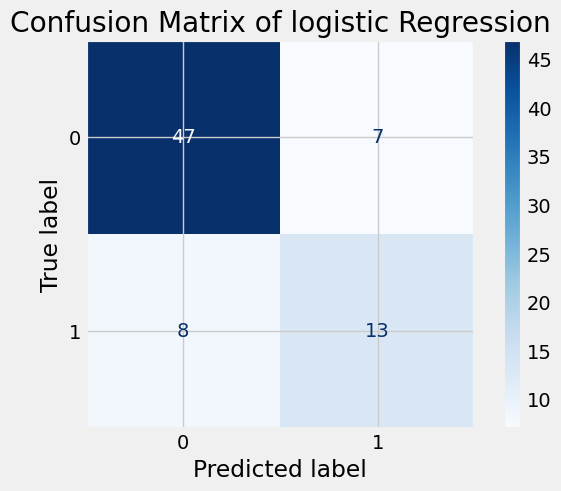

In [66]:
# Best model


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Machen Sie Vorhersagen auf dem Testdatensatz
predictions = best_model_rf.predict(features_test)

# Berechnen Sie die Confusion Matrix
cm = confusion_matrix(target_test, predictions)

# Anzeigen der Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Random-Forest')
plt.show()


#Log Regression

# Machen Sie Vorhersagen auf dem Testdatensatz
predictions = best_model_log.predict(features_test)

# Berechnen Sie die Confusion Matrix
cm = confusion_matrix(target_test, predictions)

# Anzeigen der Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of logistic Regression')
plt.show()


In [67]:
# We decide us for the RF-model

## Final Data-pipeline

We appy the full data set to our best model

In [82]:


def predict(csv_file, model):
    """Estimate waiting time in seconds for taxi-rides in the Quito area.
    
    Args:
        csv_file (str): Path of the incoming data csv file 
        model (model): The trained model.
    
    Returns:
        numpyArray: Estimated waiting time [seconds]
    """
    # Daten einlesen
    test = pd.read_csv(csv_file)


    # Daten bereinigen
    test = clean_data(test)

    # Sampling anwenden
    test = sampling_features(test)
    
    # Feature Engineering
    test = engineer_features(test)

    # Prediction
    predictions = model.predict(test)
    
    return predictions

# Beispiel für die Nutzung der Funktion
csv_file = 'features_test.csv'

# Hier entscheide ich mich für Random Forest

#best_pipe = dec_pipe_pca  # Probe ob es geht!!!!
# best_pipe = best_model_log   # Probe geht
best_pipe = best_model_rf   # Probe geht
#best_pipe = best_model_rf
#best_pipe = best_model_log  


trained_model = best_pipe # rf_pipe # Ihr trainiertes Modell
test = predict(csv_file, trained_model)
print(test)



[0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 1]


C:\Users\Trainee\AppData\Local\Temp\ipykernel_20760\1909828770.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clean['gender'] = X_clean['gender'].map({'male': 1, 'female': 0})
C:\Users\Trainee\AppData\Local\Temp\ipykernel_20760\1909828770.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clean[cat_cols_trans] = X_clean[cat_cols_trans].astype(int)


In [83]:


# def predict(csv_file_1, csv_file_2, model):
#     """Estimate waiting time in seconds for taxi-rides in the Quito area.
    
#     Args:
#         csv_file (str): Path of the incoming data csv file 
#         model (model): The trained model.
    
#     Returns:
#         numpyArray: Estimated waiting time [seconds]
#     """
#     # Daten einlesen
#     test = pd.read_csv(csv_file_1)
#     target = pd.read_csv(csv_file_2)
#     # Setzen Sie den Index auf 'id', falls nötig
#     #if 'id' in test.columns:
#     #    test.set_index('id', inplace=True)

#     # Daten bereinigen
#     test, target = clean_data(test, target)

#     # Sampling anwenden
#     test, target = sampling_features(test, target)
    
#     # Feature Engineering
#     test, target = engineer_features(test, target)

#     # Prediction
#     predictions = model.predict(test)
    
#     return predictions

# Beispiel für die Nutzung der Funktion
# csv_file_1 = 'features_test.csv'
# csv_file_2 = 'target_test.csv'

# # Hier entscheide ich mich für Random Forest

# #best_pipe = dec_pipe_pca  # Probe ob es geht!!!!
# # best_pipe = best_model_log   # Probe geht
# best_pipe = best_model_rf   # Probe geht
# #best_pipe = best_model_rf
# #best_pipe = best_model_log  


# trained_model = best_pipe # rf_pipe # Ihr trainiertes Modell
# test = predict(csv_file_1, csv_file_2, trained_model)
# print(test)



In [85]:

# Klassifikationsbericht für die Testdaten


print(classification_report(target_test, predict(csv_file, trained_model)))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94        54
           1       0.89      0.76      0.82        21

    accuracy                           0.91        75
   macro avg       0.90      0.86      0.88        75
weighted avg       0.91      0.91      0.90        75



C:\Users\Trainee\AppData\Local\Temp\ipykernel_20760\1909828770.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clean['gender'] = X_clean['gender'].map({'male': 1, 'female': 0})
C:\Users\Trainee\AppData\Local\Temp\ipykernel_20760\1909828770.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clean[cat_cols_trans] = X_clean[cat_cols_trans].astype(int)


## Model Interpretation

Um den Einkäufern des Unternehmens dein Modell schmackhaft zu machen, solltest du ihnen erklären können, welche Eigenschaften für das Modell von Bedeutung sind.

Welche Features sind laut deinem Modell für die Vorhersage am wichtigsten?

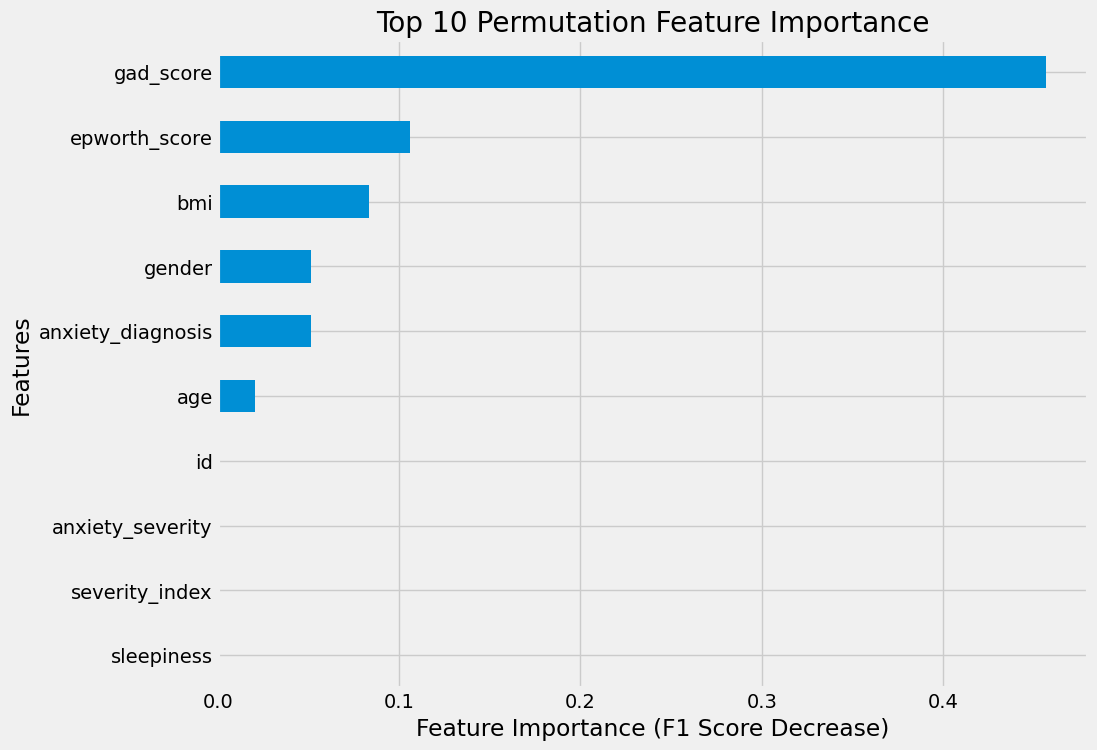

In [86]:

# Verwende das trainierte Modell (hier als Beispiel best_model_rf)
trained_model = best_model_rf 
# trained_model = best_model_log

# Berechne die ursprüngliche Genauigkeit (hier mit F1-Score)
y_pred = trained_model.predict(features_test)
f1_orig = f1_score(target_test, y_pred)

# Berechne die Permutation Feature Importance
perm_importances = []

for col in features_test.columns:
    permuted_features = features_test.copy()
    permuted_features[col] = np.random.permutation(permuted_features[col])
    permuted_pred = trained_model.predict(permuted_features)
    permuted_f1 = f1_score(target_test, permuted_pred)
    perm_important = f1_orig - permuted_f1
    perm_importances.append(perm_important)

# Erstellen einer Series mit den Permutationsimportances und den Spaltennamen als Index
perm_importance = pd.Series(perm_importances, index=features_test.columns)

# Sortieren der Werte und Auswahl der Top 10 Features
top_10_features = perm_importance.sort_values(ascending=False).head(10)

# Visualisieren der Top 10 Permutationsimportances
plt.figure(figsize=(10, 8))
top_10_features.plot(kind='barh')
plt.xlabel('Feature Importance (F1 Score Decrease)')
plt.ylabel('Features')
plt.title('Top 10 Permutation Feature Importance')
plt.gca().invert_yaxis()  # Die Reihenfolge der Features umkehren, um die wichtigste oben zu haben
plt.show()


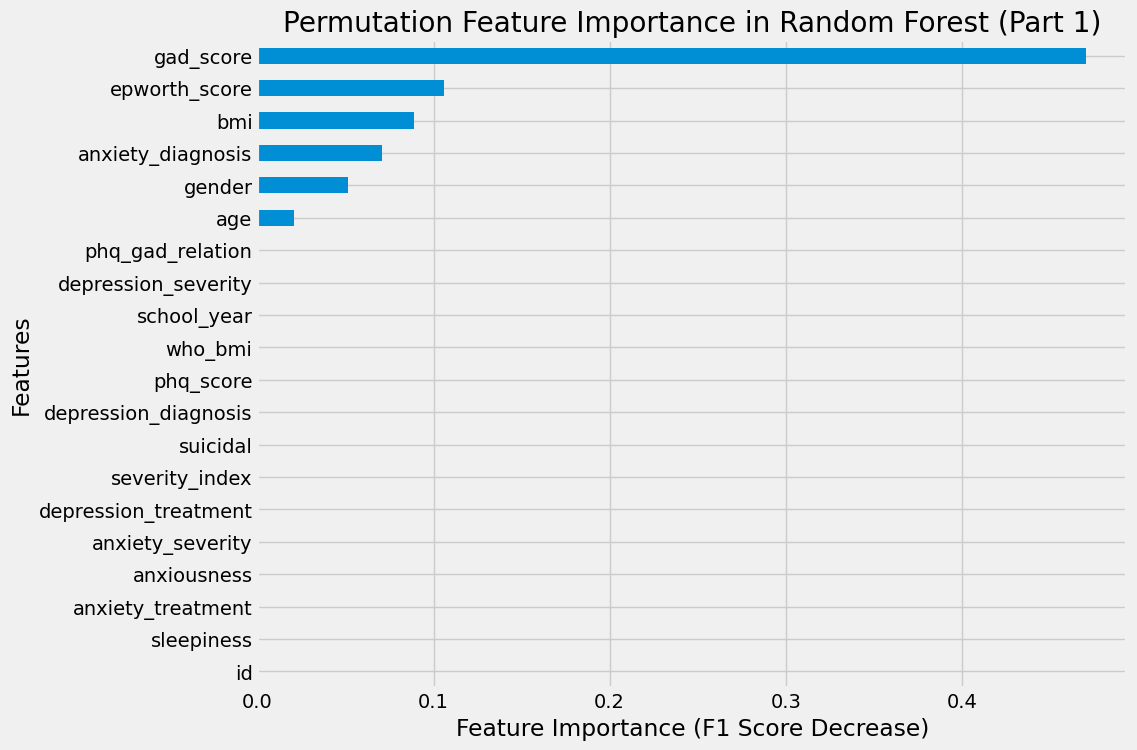

In [87]:
# Permutation Feature Importance


# Berechne die Permuation Feature Importance

# features_train, target_train    Trainingsdatensatz
# features_test, target_test      Testdatensatz

trained_model = best_model_rf 
#trained_model = best_model_log

# Berechne die ursprüngliche Genauigkeit (hier mit F1-Score)
y_pred = trained_model.predict(features_test)
f1_orig = f1_score(target_test, y_pred)

# Berechne die Permutation Feature Importance
perm_importances = []

for col in features_test.columns:
    permuted_features = features_test.copy()
    permuted_features[col] = np.random.permutation(permuted_features[col])
    permuted_pred = trained_model.predict(permuted_features)
    permuted_f1 = f1_score(target_test, permuted_pred)
    perm_important = f1_orig - permuted_f1
    perm_importances.append(perm_important)

# Erstellen einer Series mit den Permutationsimportances und den Spaltennamen als Index
perm_importance = pd.Series(perm_importances, index=features_test.columns)

# Sortieren der Werte
perm_importance = perm_importance.sort_values()

# Visualisieren der Permutationsimportances
plt.style.use('fivethirtyeight')


# Anzahl der Features pro Plot
features_per_plot = 32

# Anzahl der Plots berechnen
num_plots = int(np.ceil(len(perm_importance) / features_per_plot))

for i in range(num_plots):
    start = i * features_per_plot
    end = start + features_per_plot
    subset_perm_importance = perm_importance[start:end]
    
    subset_perm_importance.plot(kind='barh', figsize=(10, 8))
    plt.xlabel('Feature Importance (F1 Score Decrease)')
    plt.ylabel('Features')
    plt.title(f'Permutation Feature Importance in Random Forest (Part {i+1})')
    plt.show()



Wie ändert sich deine durchschnittliche Vorhersage, wenn du den Meilenstand `'VehOdo'` bzw. das Alter `'VehicleAge'` variierst. Würdest du das so erwarten?

In [88]:
print(features_train.columns)

important_feature = ['cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'age_60_and_above', 'gender', 'year',
       'month', 'day', 'weekday']

important_features_cat = [ 'test_indication', 'weekday_name']

Index(['id', 'school_year', 'age', 'gender', 'bmi', 'who_bmi', 'phq_score',
       'depression_severity', 'suicidal', 'depression_diagnosis',
       'depression_treatment', 'gad_score', 'anxiety_severity', 'anxiousness',
       'anxiety_diagnosis', 'anxiety_treatment', 'epworth_score', 'sleepiness',
       'severity_index', 'phq_gad_relation'],
      dtype='object')


In [89]:
print(best_pipe)

Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'gender', 'bmi',
                                                   'gad_score',
                                                   'anxiety_diagnosis',
                                                   'epworth_score']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
              

## Abschluss des Projekts

In der Datei *features_aim.csv* findest du die Features für deine abschließende Vorhersage.
Speichere nur deine vorhergesagten Werte für `'IsBadBuy'` in einer CSV-Datei namens 
`predictions_aim.csv`. Wie viele Käufe in den Zieldaten sollten laut deinem Modell lieber nicht getätigt werden?

In [90]:
import pandas as pd

def fit(csv_file, model, target):
    """ Final fitting of the best model
    
    Args:
        csv_file (str): Path of the incoming data csv file.
        model: The trained model.
        target (list of str): List of target column names.
    
    Returns:
        model: Fitted model.
    """
    # Read the datafile
    df = pd.read_csv(csv_file)

    # Skip the NaN of the Target
    df_clean = clean_data_target(df, target)
    
    # Separate features and target
    features = df_clean.drop(columns=target)
    target = df_clean[target]

    # Optional additional cleaning if needed
    features, target = clean_data(features, target)

    # Apply sampling
    features, target = sampling_features(features, target)
    
    # Feature Engineering
    features, target = engineer_features(features, target)

    # Fit the model
    fitted_model = model.fit(features, target)
    
    return fitted_model

# Original and full dataset for the final training

csv_file = 'data/depression_anxiety_data.csv'
target = ['depressiveness']
trained_model = best_pipe  # Best model (assumed to be defined elsewhere)

fitted_model = fit(csv_file, trained_model, target)


In [91]:

# Abschluss für die Vorhersage
csv_file = 'aim_test.csv'
trained_model = fitted_model # Bestes Modell

# Vorhersagen berechnen
is_corona_predictions = predict(csv_file, trained_model)

# Anzahl der Käufe, die laut Modell nicht getätigt werden sollten
num_corona = sum(is_corona_predictions)

# Vorhersagen in einer CSV-Datei speichern
predictions_df = pd.DataFrame({'IsCorona': is_corona_predictions})
predictions_df.to_csv('predictions_aim.csv', index=False)

# Anzahl der "Bad Buys" ausgeben
print(f"Anzahl der Corona-Fälle sind: {num_corona}")





Anzahl der Corona-Fälle sind: 1
